In [1]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
from pyproj import CRS, Transformer
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
import torchvision.models as models
from copy import deepcopy
from tqdm import tqdm
class Normalizer:
    """
    Image normalization (log1p + robust/global z) + Pandora normalization.
    Fit ONLY on training data to avoid leakage.
    """
    def __init__(self, clip_z=5.0,enforce_nonneg=True):
        self.clip_z = float(clip_z)
        self.enforce_nonneg = bool(enforce_nonneg)
        self.im_mu = None
        self.im_sigma = None       

    def fit_images(self, tif_paths):
        vals = []
        f32min = np.float32(-3.4028235e+38).item()

        for p in tif_paths:
            with rasterio.open(p) as src:
                arr = src.read(1).astype("float64")            
            m = np.isfinite(arr) & (arr > f32min*0.9)
            if self.enforce_nonneg:
                arr = np.where(m, np.maximum(arr, 0.0), np.nan) #clip negatives to zero
                m = np.isfinite(arr) #sanity check
                
            v = np.log1p(arr[m])  # log1p
            if v.size:
                vals.append(v)
        if not vals:
            raise RuntimeError("No valid pixels found to fit image normalizer.")
        allv = np.concatenate(vals)
        mu = np.median(allv)
        iqr = np.percentile(allv, 75) - np.percentile(allv, 25)
        sigma = max(iqr / 1.349, 1e-6)
        self.im_mu, self.im_sigma = float(mu), float(sigma)

    def normalize_image(self, arr_float64):
        f32min = np.float32(-3.4028235e+38).item()
        m = np.isfinite(arr_float64) & (arr_float64 > f32min * 0.9)
        x = arr_float64.copy()
        if self.enforce_nonneg: x[m] = np.maximum(x[m], 0.0)
        z = np.zeros_like(x, dtype=np.float32)
        z[~m] = 0.0
        z[m] = ((np.log1p(x[m]) - self.im_mu) / self.im_sigma)
        z[m] = np.clip(z[m], -self.clip_z, self.clip_z)
        return z

    def denormalize_image(self, z_float32):
        z = np.clip(z_float32.astype("float64"), -5, 5)  # match training range
        return np.expm1(z * self.im_sigma + self.im_mu)


# normalizer.fit_images(train_files)
# np.savez("normalizer_stats.npz",
#          im_mu=normalizer.im_mu, im_sigma=normalizer.im_sigma)


In [2]:
def load_classification_pickle(input_file="/hpc/home/srs108/TEMPO/file_classification_nop.pkl"):
    """Load from pickle"""
    
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    
    return data["complete"], data["partial"], data["blank"]
# save_classification_pickle(complete, partial, blank, output_file="file_classification_nop.pkl")
complete, partial, blank = load_classification_pickle()
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'

z = np.load("normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)

normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"

In [3]:
class TempoInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None):
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT


    def sample_vis(self, idx=None):
        if idx is None:
            idx = np.random.randint(len(self))
        sample = self[idx]

        inp_np = sample["img_w_both_masks"][0].numpy()
        mask_obs = sample["known_mask"][0].numpy().astype(bool)
        mask_eff = sample["known_and_fake_mask"][0].numpy().astype(bool)
        targ = sample['target'][0].numpy()
        mask_sp = sample['fake_mask'][0].numpy().astype(bool)

        vmin, vmax = np.percentile(inp_np[np.isfinite(inp_np)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        fig, ax = plt.subplots(1, 5, figsize=(22, 6))

        im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_eff),
                           cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_title("Input (masked)")
        fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        ax[1].imshow(mask_obs == 0, cmap="Reds", alpha=0.7)
        ax[1].set_title("Observed Holes (sensor)")

        ax[2].imshow(mask_sp == 0, cmap="Blues", alpha=0.7)
        ax[2].set_title("Artificial Holes (S+P)")
        
        ax[3].imshow(mask_eff == 0, cmap="gray", alpha=0.7)
        ax[3].set_title("Effective Mask (used in training)")
        
        im5 = ax[4].imshow(np.ma.array(targ),
                           cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[4].set_title("Regular Input")
        fig.colorbar(im5, ax=ax[4], fraction=0.046, pad=0.04)

        for a in ax: a.axis("off")
        plt.tight_layout()
        plt.show()

        
    # ---------- torch Dataset API ----------
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)

        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img)  # target scale

        # --- Artificial salt & pepper mask ---
        mask_sp_keep = np.ones((H, W), dtype=np.float32)
        if self.train:
            frac = 0.02  # 2% of pixels dropped

            # Only consider pixels that are valid in known_mask (i.e., known_mask == 1)
            valid_pixel_indices = np.where(known_mask.flatten() == 1)[0]
            num_valid_pixels = len(valid_pixel_indices)

            if num_valid_pixels > 0:
                num_holes = int(frac * num_valid_pixels)

                # Randomly pick indices from valid pixels only
                selected_indices = np.random.choice(valid_pixel_indices, size=min(num_holes, num_valid_pixels), replace=False)
                mask_sp_keep = np.ones(H * W, dtype=np.float32)
                mask_sp_keep[selected_indices] = 0.0
                mask_sp_keep = mask_sp_keep.reshape(H, W)

        all_masks = known_mask 
        img_with_holes = img_n * all_masks
     
        sample = {
            "img_w_both_masks": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         #input image to model with all holes real +fake
            "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       # mask used in training, 
            "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(), # real missing pixels only, 1=pixel available, 0=no pixel available
            "fake_mask": torch.from_numpy(mask_sp_keep).unsqueeze(0).float(),          # salt/pepper holes
            "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
            "path": path,
        }
        return sample
    
train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, file_list=train_files ,train=True)
train_ds.sample_vis(300)


In [4]:
class PConv2D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, use_bias=True, activation=None):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.activation = activation if activation is not None else nn.Identity()

        # Image kernel
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride,
                              padding=kernel_size // 2, bias=use_bias)

        # Fixed mask kernel (all ones)
        self.register_buffer("mask_kernel",
                             torch.ones(1, 1, kernel_size, kernel_size))

    def forward(self, img, mask):
        # Apply mask to image
        img_masked = img * mask

        # Convolution
        img_out = self.conv(img_masked)

        # Convolve mask (counts valid pixels)
        with torch.no_grad():
            mask_out = F.conv2d(mask, self.mask_kernel,
                                stride=self.stride, padding=self.kernel_size // 2)
            mask_out = torch.clamp(mask_out, 0, 1)

        # Normalize by valid ratio
        n = self.kernel_size * self.kernel_size
        mask_ratio = n / (mask_out + 1e-8)
        mask_ratio = mask_ratio * mask_out
        img_out = img_out * mask_ratio

        return self.activation(img_out), mask_out

class PConvUNet2D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32):
        super().__init__()

        # Encoder
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc4 = PConv2D(base_ch*4, base_ch*8, stride=2, activation=nn.LeakyReLU(0.1))

        # Bottleneck
        self.bot  = PConv2D(base_ch*8, base_ch*8, activation=nn.LeakyReLU(0.1))

        # Decoder
        self.up3  = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = PConv2D(base_ch*8, base_ch*4, activation=nn.LeakyReLU(0.1))

        self.up2  = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))

        self.up1  = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))

        # Final output
        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, img, mask):
        masks = []
        # Encoder
        e1, m1 = self.enc1(img, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)
        e4, m4 = self.enc4(e3, m3)

        # Bottleneck
        b, mb = self.bot(e4, m4)

        # Decoder
        d3_in = torch.cat([self.up3(b), e3], dim=1)
        m3_in = torch.maximum(F.interpolate(mb, scale_factor=2, mode="nearest"), m3)
        d3, md3 = self.dec3(d3_in, m3_in)

        d2_in = torch.cat([self.up2(d3), e2], dim=1)
        m2_in = torch.maximum(F.interpolate(md3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        d1_in = torch.cat([self.up1(d2), e1], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1


In [15]:
def _load_shapefile_segments_pyshp(shp_path, target_crs):
    prj_path = os.path.splitext(shp_path)[0] + ".prj"
    if os.path.exists(prj_path):
        with open(prj_path, "r") as f:
            wkt = f.read()
        try:
            src_crs = CRS.from_wkt(wkt)
        except Exception:
            src_crs = CRS.from_epsg(4326)
    else:
        src_crs = CRS.from_epsg(4326)

    tgt = target_crs if hasattr(target_crs, "to_wkt") else None
    if tgt is None:
        return None
    
    transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

    r = shapefile.Reader(shp_path)
    segments = []
    for shapeRec in r.shapeRecords():
        shp = shapeRec.shape
        pts = np.asarray(shp.points, dtype=float)
        if pts.size == 0: 
            continue
        xs, ys = transformer.transform(pts[:,0], pts[:,1])
        pts_t = np.column_stack([xs, ys])
        parts = list(shp.parts) + [len(pts_t)]
        for i in range(len(parts)-1):
            seg = pts_t[parts[i]:parts[i+1]]
            if seg.shape[0] >= 2:
                segments.append(seg)
    return segments

def safe_spearman(x, y):
    from scipy.stats import spearmanr
    try:
        return spearmanr(x, y)[0]
    except Exception:
        return np.nan

def visualize_batch(epoch,model, dataset, idx, device="cuda", save=False, shp_path=shp_path, avg_thr=0.2):
    model.eval()
    sample = dataset[idx]   # dict: {"img_in","mask_in","target","path"}
    img    = sample["img_w_both_masks"].unsqueeze(0).to(device)   # [1,1,H,W]
    mask   = sample["known_and_fake_mask"].unsqueeze(0).to(device)  # [1,1,H,W]
    target = sample["target"].unsqueeze(0).to(device)   # [1,1,H,W]

    with torch.no_grad():
        pred, out_mask  = model(img, mask)
    
    inp_np   = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_np  = mask[0,0].cpu().numpy().astype(bool)   # 1=known
    pred_np  = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np   = normalizer.denormalize_image(target[0,0].cpu().numpy())

#     inp_np   = img[0,0].cpu().numpy()
#     mask_np  = mask[0,0].cpu().numpy().astype(bool)   # 1=known
#     pred_np  = pred[0,0].cpu().numpy()
#     tgt_np   = target[0,0].cpu().numpy()
    
    holes_before = np.count_nonzero(~mask_np)
    holes_filled = np.count_nonzero((~mask_np) & np.isfinite(pred_np))
    fill_frac = 100.0 * holes_filled / max(holes_before, 1)

    path = sample["path"]
    base = os.path.basename(path)
    ts = re.sub(r"\D", "", base)[:14]
    date = datetime.strptime(ts, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width
        xmin, ymin, xmax, ymax = src.bounds

    segments = _load_shapefile_segments_pyshp(shp_path, crs)
    inv = ~tr
    seg_pix = []
    for seg in segments:
        cols, rows = [], []
        for x, y in seg:
            c, r = inv * (x, y)
            cols.append(c)
            rows.append(r)
        seg_pix.append(np.column_stack([cols, rows]))
    segments = seg_pix

    def _add_shape(a, alpha=1.0, color="k"):
        a.add_collection(LineCollection(segments, colors=color, linewidths=0.6, zorder=6, alpha=alpha))

    try:
        gy = ndi.sobel(pred_np, axis=0); gx = ndi.sobel(pred_np, axis=1)
    except Exception:
        gy, gx = np.gradient(pred_np.astype(np.float32))
    grad = np.hypot(gx, gy)

    known_grad = grad[(mask_np) & np.isfinite(grad)]
    if known_grad.size:
        p10, p90 = np.percentile(known_grad, [10, 90])
        scale = max(p90 - p10, 1e-6)
        grad_norm = (grad - p10) / scale
    else:
        grad_norm = grad

    avg_mask = (~mask_np) & (grad_norm < float(avg_thr))  # holes with low texture
    avg_frac = 100.0 * (avg_mask.sum() / max((~mask_np).sum(), 1))

    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")

    finite = np.isfinite(tgt_np)
    vmin, vmax = (np.percentile(tgt_np[finite], [2, 98]) if finite.any() else (0, 1))

    inp_ma   = np.ma.array(inp_np,   mask=~mask_np)   # holes → white
    tgt_ma   = np.ma.array(tgt_np,  mask=~np.isfinite(tgt_np))
    pred_ma  = np.ma.array(pred_np, mask=np.isfinite(pred_np))

    # --- Plot panels ---
    fig, ax = plt.subplots(1, 4, figsize=(15, 7))
    im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_np), cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper")
    ax[0].set_title("Input (holes = white)");_add_shape(ax[0], color="k")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(mask_np, cmap="gray", extent=(0, W, H, 0), origin="upper")
    ax[1].set_title("Known Mask");_add_shape(ax[1], color="r")

    im2 = ax[2].imshow(np.ma.array(pred_np, mask=~np.isfinite(pred_np)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper", zorder=5)
    ax[2].set_title(f"{fill_frac:.1f}%");_add_shape(ax[2], color="k")
    fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    # filled_only: prediction values only in holes
    filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
    filled_only[~mask_np] = pred_np[~mask_np]   # keep values only where mask==0

    # masked array: holes show predictions, known pixels hidden
    im3 = ax[3].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper", zorder=5)
    ax[3].set_title("Filled Values in Holes");_add_shape(ax[3], color="k");fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

    for a in ax: a.axis("off")

    fig.suptitle(f"Validation image {date}, epoch {epoch}", fontsize=16)
    plt.tight_layout()
    save_path = path.split('/')[-1].split('.')[0]
    if save:
        plt.savefig(f'{save_path}_epoch_{epoch}.png', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

100%|██████████| 1043/1043 [04:32<00:00,  3.83it/s]


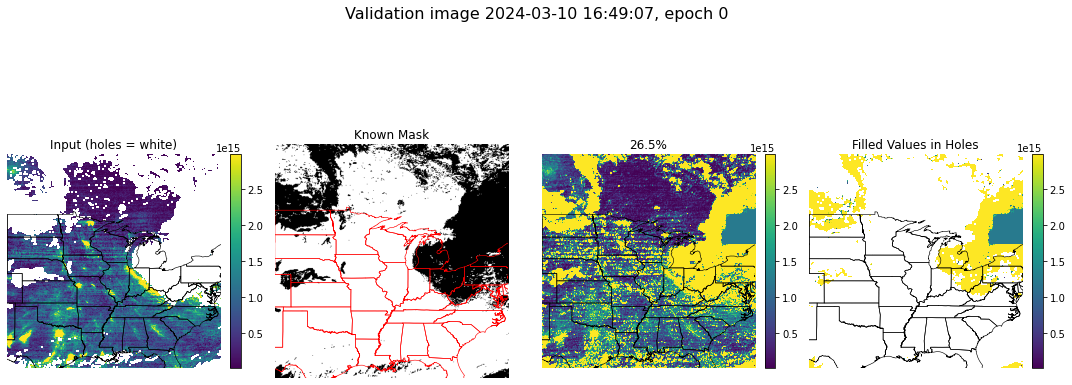

100%|██████████| 261/261 [00:52<00:00,  4.94it/s]


Epoch 1: Train 15.9662 | Val 0.6113


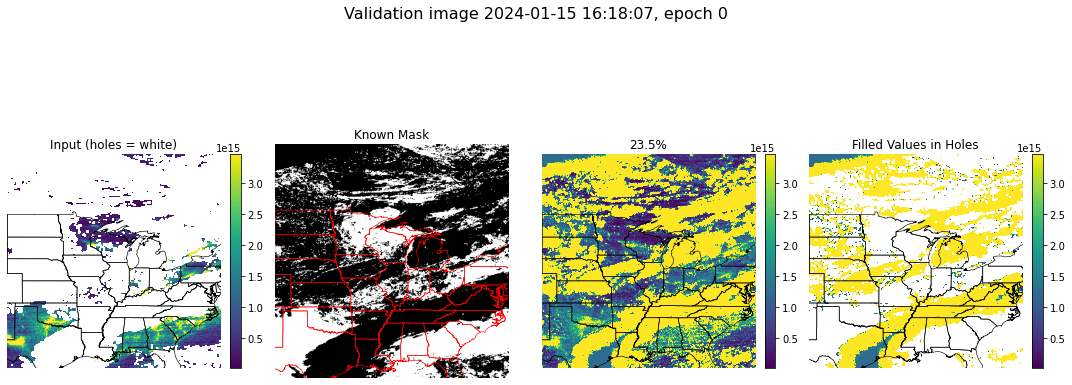

 34%|███▎      | 350/1043 [01:28<02:54,  3.96it/s]


KeyboardInterrupt: 

In [6]:
train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files)
val_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)


def warmup_loss(pred, target, mask):
    hole_mask = 1- mask
    if mask.ndim == 3:  # ensure channel dim
        mask = mask.unsqueeze(1)
    valid_mask = mask.float()

    diff = (pred - target) * valid_mask
    l1_iden = torch.sum(torch.abs(diff)) / (valid_mask.sum() + 1e-8)

    return l1_iden 

def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    wait = 0

    history =[]
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader):
            img   = batch["img_w_both_masks"].cuda()          #img with both masks
            mask  = batch["known_and_fake_mask"].cuda()       # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()              # 1=kept, 0=artificial hole
            target= batch["target"].cuda()

            pred_t, pred_mask = model(img, mask)
#             if epoch < 10:
            loss = warmup_loss(pred_t,target,mask)
#             else: loss = criterion(pred_t, target, mask)
            
            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
        visualize_batch(epoch, model, train_ds, idx=300, device="cuda")
        
#         print(f"Target range: {target.min().item():.2f}, {target.max().item():.2f}")
#         print(f"Pred range: {pred.min().item():.2f}, {pred.max().item():.2f}")

            
        train_loss /= len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img   = batch["img_w_both_masks"].cuda()
                mask  = batch["known_and_fake_mask"].cuda()
                target= batch["target"].cuda()
                pred, pred_mask = model(img, mask)
#                 if epoch < 10:
                loss = warmup_loss(pred,target,mask)
#                 else: loss = criterion(pred, target, mask)
                val_loss += loss.item()
        val_loss /= len(val_loader)
    
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        
        fill_frac = visualize_batch(epoch, model, val_ds, idx=19, device="cuda")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "pred_min_range": pred_t.min().item(),
            "pred_max_range": pred_t.max().item()
        })
        
        with open('csv_history.csv', "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=["epoch","train_loss","val_loss", "pred_min_range", "pred_max_range"])
            writer.writeheader()
            writer.writerows(history)
        
    # Restore best weights
    model.load_state_dict(best_state)
    return model

model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = train_model(model, train_loader, val_loader, epochs=150, patience=20)

Epoch 1/50 [train]: 100%|██████████| 1043/1043 [04:28<00:00,  3.88it/s]


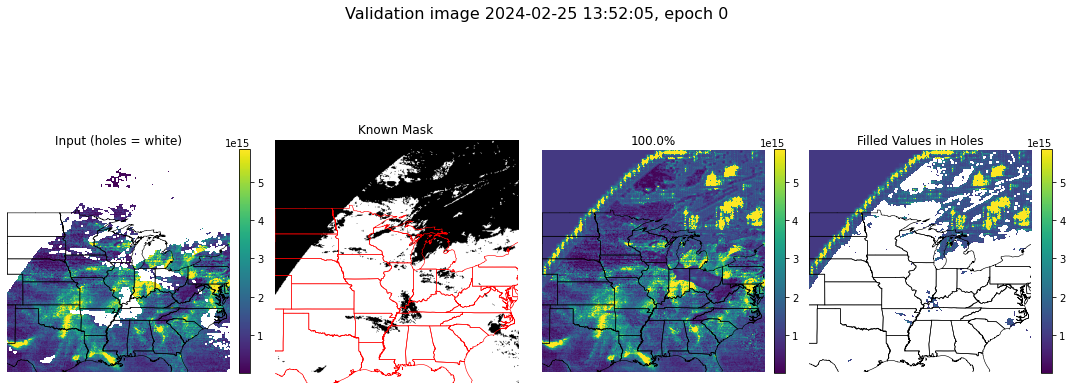

Epoch 2/50 [train]:   0%|          | 0/1043 [00:00<?, ?it/s]

Epoch 001 | Train: total 0.0037 (id 0.0037, hole 0.0013) | Val: total 0.0031 (id 0.0031, hole 0.0000) | w_id=1.00, w_hole=0.00


Epoch 2/50 [train]:  96%|█████████▋| 1006/1043 [04:14<00:09,  3.97it/s]

In [ ]:
import csv, math, torch
import torch.nn.functional as F
from tqdm import tqdm

EPS = 1e-8

def mae_masked(pred, target, mask, weight=None):
    """
    pred,target: [B,1,H,W]
    mask:        [B,1,H,W]  (1=include pixel, 0=exclude)
    weight:      optional [B,1,H,W] to reweight inside mask (still MAE)
    """
    diff = (pred - target).abs() * mask
    if weight is not None:
        diff = diff * weight
    denom = mask.sum().clamp_min(EPS)
    return diff.sum() / denom

def hole_center_weights(fake_mask, k=9):
    """
    fake_mask: 1=kept, 0=artificial hole.
    Returns a weight map (same shape) in [0.3, 1.0] *inside holes only*,
    larger toward the hole center to discourage flat fills.
    """
    # average of fake_mask around each location: near hole center ~0, boundary ~0.5–1
    avg = F.avg_pool2d(fake_mask, kernel_size=k, stride=1, padding=k//2)
    # turn that into weights: smaller avg -> bigger weight
    w = 0.3 + 0.7 * (1.0 - avg)          # [0.3..1.0]
    hole = (1.0 - fake_mask)              # 1 in artificial holes
    return w * hole                       # weights only where hole==1

def train_model(
    model, train_loader, val_loader,
    epochs=50, patience=5, device="cuda",
    warmup_epochs=10, hole_ramp_epochs=10,
    id_weight_after=0.3,                # identity MAE weight after ramp
    csv_path="history_mae.csv",
    lr=1e-5
):
    """
    MAE-only training with 3 phases:
    - [0, warmup): identity MAE on visible pixels only (known)
    - [warmup, warmup+hole_ramp): mix identity + hole MAE with linear ramp
    - [warmup+hole_ramp, ...): hole MAE dominates; identity kept at small weight
    """
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    wait = 0
    history = []

    def mix_weights(epoch):
        if epoch < warmup_epochs:
            return 1.0, 0.0   # id only
        t = (epoch - warmup_epochs) / max(hole_ramp_epochs, 1)
        t = float(min(max(t, 0.0), 1.0))
        w_hole = t
        w_id   = (1.0 - t) + t * id_weight_after
        return w_id, w_hole

    for epoch in range(epochs):
        w_id, w_hole = mix_weights(epoch)

        # -------- train --------
        model.train()
        tr_total, tr_id, tr_hole = 0.0, 0.0, 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]"):
            img   = batch["img_w_both_masks"].to(device)       # [B,1,H,W]
            mask  = batch["known_and_fake_mask"].to(device)    # [B,1,H,W] 1=visible
            fake  = batch["fake_mask"].to(device)              # [B,1,H,W] 0=artificial hole
            tgt   = batch["target"].to(device)

            pred, _ = model(img, mask)

            # identity MAE on *visible* pixels (what the model actually sees)
            loss_id   = mae_masked(pred, tgt, mask)

            # hole MAE on artificial holes only (where fake==0)
            hole_mask = 1.0 - fake
            if hole_mask.sum() > 0:
                w_center = hole_center_weights(fake, k=9)   # still MAE, just reweighted
                loss_hole = mae_masked(pred, tgt, hole_mask, weight=w_center)
            else:
                loss_hole = pred.new_tensor(0.0)

            loss = w_id * loss_id + w_hole * loss_hole

            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_total += loss.item()
            tr_id    += loss_id.item()
            tr_hole  += loss_hole.item()

        ntr = max(len(train_loader), 1)
        tr_total /= ntr; tr_id /= ntr; tr_hole /= ntr
        visualize_batch(epoch, model, train_ds, idx=222, device="cuda", save=False)

        # -------- validate --------
        model.eval()
        val_total, val_id, val_hole = 0.0, 0.0, 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [val]"):
                img   = batch["img_w_both_masks"].to(device)
                mask  = batch["known_and_fake_mask"].to(device)
                fake  = batch["fake_mask"].to(device)
                tgt   = batch["target"].to(device)

                pred, _ = model(img, mask)

                li = mae_masked(pred, tgt, mask)
                hole_mask = 1.0 - fake
                if hole_mask.sum() > 0:
                    w_center = hole_center_weights(fake, k=9)
                    lh = mae_masked(pred, tgt, hole_mask, weight=w_center)
                else:
                    lh = pred.new_tensor(0.0)

                v = w_id * li + w_hole * lh
                val_total += v.item()
                val_id    += li.item()
                val_hole  += lh.item()

        nval = max(len(val_loader), 1)
        val_total /= nval; val_id /= nval; val_hole /= nval

        print(f"Epoch {epoch+1:03d} | "
              f"Train: total {tr_total:.4f} (id {tr_id:.4f}, hole {tr_hole:.4f}) | "
              f"Val: total {val_total:.4f} (id {val_id:.4f}, hole {val_hole:.4f}) | "
              f"w_id={w_id:.2f}, w_hole={w_hole:.2f}")

        history.append({
            "epoch": epoch+1,
            "train_total": tr_total,
            "train_id": tr_id,
            "train_hole": tr_hole,
            "val_total": val_total,
            "val_id": val_id,
            "val_hole": val_hole,
            "w_id": w_id,
            "w_hole": w_hole
        })

        # early stopping on val_total
        if val_total < best_val - 1e-6:
            best_val = val_total
            wait = 0
            torch.save(model.state_dict(), "best_pconv_mae.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # write CSV each epoch
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(
                f, fieldnames=list(history[0].keys()))
            writer.writeheader()
            writer.writerows(history)

    return history
train_model(model, train_loader, val_loader,epochs=50, patience=5, device="cuda",warmup_epochs=5, hole_ramp_epochs=10,
id_weight_after=0.3,               
csv_path="history_mae.csv",
lr=1e-5
)

In [7]:
model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model.load_state_dict(torch.load('/work/srs108/pconvunet.pt'))
# model = train_model(model, train_loader, val_loader, epochs=150, patience=20)

<All keys matched successfully>

  0%|          | 0/261 [00:00<?, ?it/s]

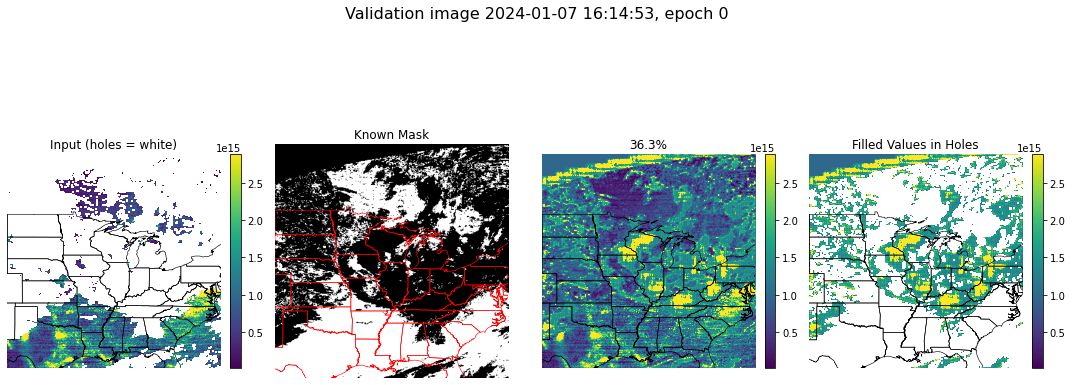

  0%|          | 1/261 [00:16<1:10:21, 16.24s/it]

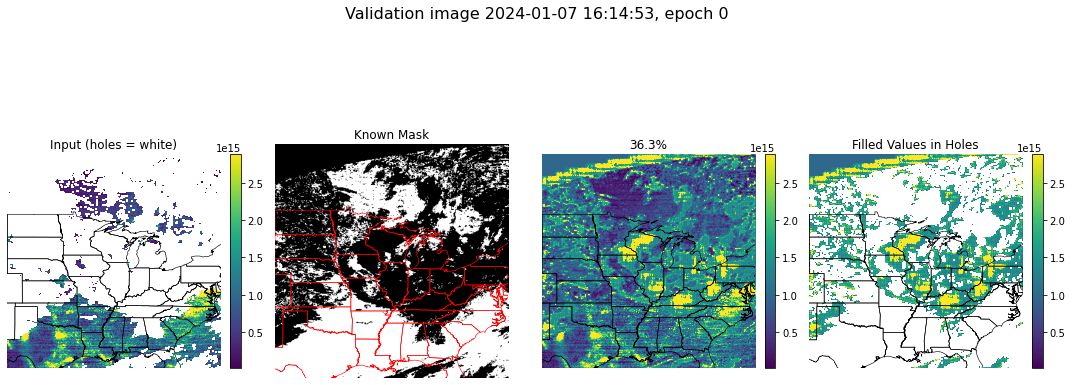

  1%|          | 2/261 [00:35<1:16:02, 17.61s/it]


KeyboardInterrupt: 

In [10]:
with torch.no_grad():
    for i in 
        visualize_batch(0, model, val_ds, idx=i, device="cuda")

In [10]:
# # ---- Losses / Metrics ----
# def warmup_loss(pred, target, mask_obs):
#     """Force reconstruction of observed (real valid) pixels only"""
#     diff = (pred - target) * mask_obs
#     return torch.sum(torch.abs(diff)) / (mask_obs.sum() + 1e-8)

# def mae_gaps(pred, target, val_mask):
#     m = val_mask.bool()
#     return torch.mean(torch.abs(pred[m] - target[m]))

# def rmse_gaps(pred, target, val_mask):
#     m = val_mask.bool()
#     return torch.sqrt(torch.mean((pred[m] - target[m])**2))

# def r2_gaps(pred, target, val_mask):
#     m = val_mask.bool()
#     y_true, y_pred = target[m], pred[m]
#     ss_res = torch.sum((y_true - y_pred)**2)
#     ss_tot = torch.sum((y_true - y_true.mean())**2)
#     return 1 - ss_res / (ss_tot + 1e-8)




# def train_model(model, train_loader, val_loader, epochs=50, patience=5, warmup_epochs=2):
#     opt = torch.optim.Adam(model.parameters(), lr=5e-5)
#     best_loss = float("inf")
#     best_state = None
#     wait = 0
#     history = []
    


#     for epoch in range(epochs):
#         model.train()
#         train_loss, train_mae, train_rmse, train_r2 = 0, 0, 0, 0

#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]"):
#             img   = batch["img_w_both_masks"].cuda()          #img with both masks
#             mask  = batch["known_and_fake_mask"].cuda()       # real missing gaps and artificial gaps
#             mask_aug = batch["fake_mask"].cuda()              # 1=kept, 0=artificial hole
#             target= batch["target"].cuda()

#             pred, _ = model(img, mask)

#             if epoch < warmup_epochs:
#                 loss = warmup_loss(pred, target, mask)   # supervise only on valid pixels
#             else:
#                 loss = mae_gaps(pred, target, 1 - mask)  # supervise artificial gaps only

#             visualize_batch(epoch, model, train_ds, idx=300, device="cuda")
#             opt.zero_grad()
#             loss.backward()
#             opt.step()

#             train_loss += loss.item()
# #             if epoch >= warmup_epochs:  # only meaningful after gaps are introduced
# #                 train_mae  += mae_gaps(pred, target, 1 - mask_aug).item()
# #                 train_rmse += rmse_gaps(pred, target, 1 - mask_aug).item()
# #                 train_r2   += r2_gaps(pred, target, 1 - mask_aug).item()

# #         n_batches = len(train_loader)
# #         train_loss /= n_batches
# #         if epoch >= warmup_epochs:
# #             train_mae  /= n_batches
# #             train_rmse /= n_batches
# #             train_r2   /= n_batches

# #         # ---------------- Validation ----------------
# #         model.eval()
# #         val_loss, val_mae, val_rmse, val_r2 = 0, 0, 0, 0
# #         with torch.no_grad():
# #             for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [val]"):
# #                 img   = batch["img_in"].cuda()
# #                 mask  = batch["mask_effective"].cuda()          # effective mask (real+artificial)
# #                 mask_aug = batch["mask_artificial"].cuda()      # 1=kept, 0=artificial hole
# #                 target= batch["target"].cuda()

# #                 pred, _ = model(img, mask)

# #                 if epoch < warmup_epochs:
# #                     loss = warmup_loss(pred, target, mask_aug)
# #                 else:
# #                     loss = mae_gaps(pred, target, 1 - mask)

# #                 val_loss += loss.item()
# #                 if epoch >= warmup_epochs:
# #                     val_mae  += mae_gaps(pred, target, 1 - mask_aug).item()
# #                     val_rmse += rmse_gaps(pred, target, 1 - mask_aug).item()
# #                     val_r2   += r2_gaps(pred, target, 1 - mask_aug).item()

# #         n_val_batches = len(val_loader)
# #         val_loss /= n_val_batches
# #         if epoch >= warmup_epochs:
# #             val_mae  /= n_val_batches
# #             val_rmse /= n_val_batches
# #             val_r2   /= n_val_batches
# #         fill_frac = visualize_batch(epoch, model, train_ds, idx=300, device="cuda")

# #         # ---------------- Logging ----------------
# #         print(f"Epoch {epoch+1:03d} | "
# #               f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
# #               f"MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")

# #         history.append({
# #             "epoch": epoch+1,
# #             "train_loss": train_loss,
# #             "val_loss": val_loss,
# #             "val_mae": val_mae,
# #             "val_rmse": val_rmse,
# #             "val_r2": val_r2,
# #         })

# #         # Early stopping
# #         if val_loss < best_loss:
# #             best_loss = val_loss
# #             best_state = model.state_dict()
# #             wait = 0
# #             torch.save(model.state_dict(), "best_model.pt")
# #         else:
# #             wait += 1
# #             if wait >= patience:
# #                 print(f"Early stopping at epoch {epoch+1}")
# #                 break

# #         # Save history CSV
# #         with open("training_history.csv", "w", newline="") as f:
# #             writer = csv.DictWriter(f, fieldnames=["epoch","train_loss","val_loss","val_mae","val_rmse","val_r2"])
# #             writer.writeheader()
# #             writer.writerows(history)

# #     # Restore best weights
# #     if best_state is not None:
# #         model.load_state_dict(best_state)
# #     return model, history


# # model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
# # train_model(model, train_loader, val_loader, epochs=150, patience=20)

